In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import shapely
import shapely.affinity
from scipy.constants import epsilon_0, speed_of_light
from shapely.ops import clip_by_rect
from skfem import Basis, ElementTriP0
from skfem.io.meshio import from_meshio

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from femwell.visualization import plot_domains

In [ ]:
# modifying default look of plot to increase font size and figure size
plt.rcParams["figure.figsize"] = [20, 10]

plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=16)

## General Stack Parameters

In [18]:
si_thickness = 0.22
box_thickness = 2.5

rib_etch_thickness = 0.1

## Material Parameters

In [19]:
n_si = 3.475
n_box = 1.445

## Waveguide Mode Analysis

In [ ]:
waveguides = {"ridge1550": {"width": 0.5, "height": 0.22}}

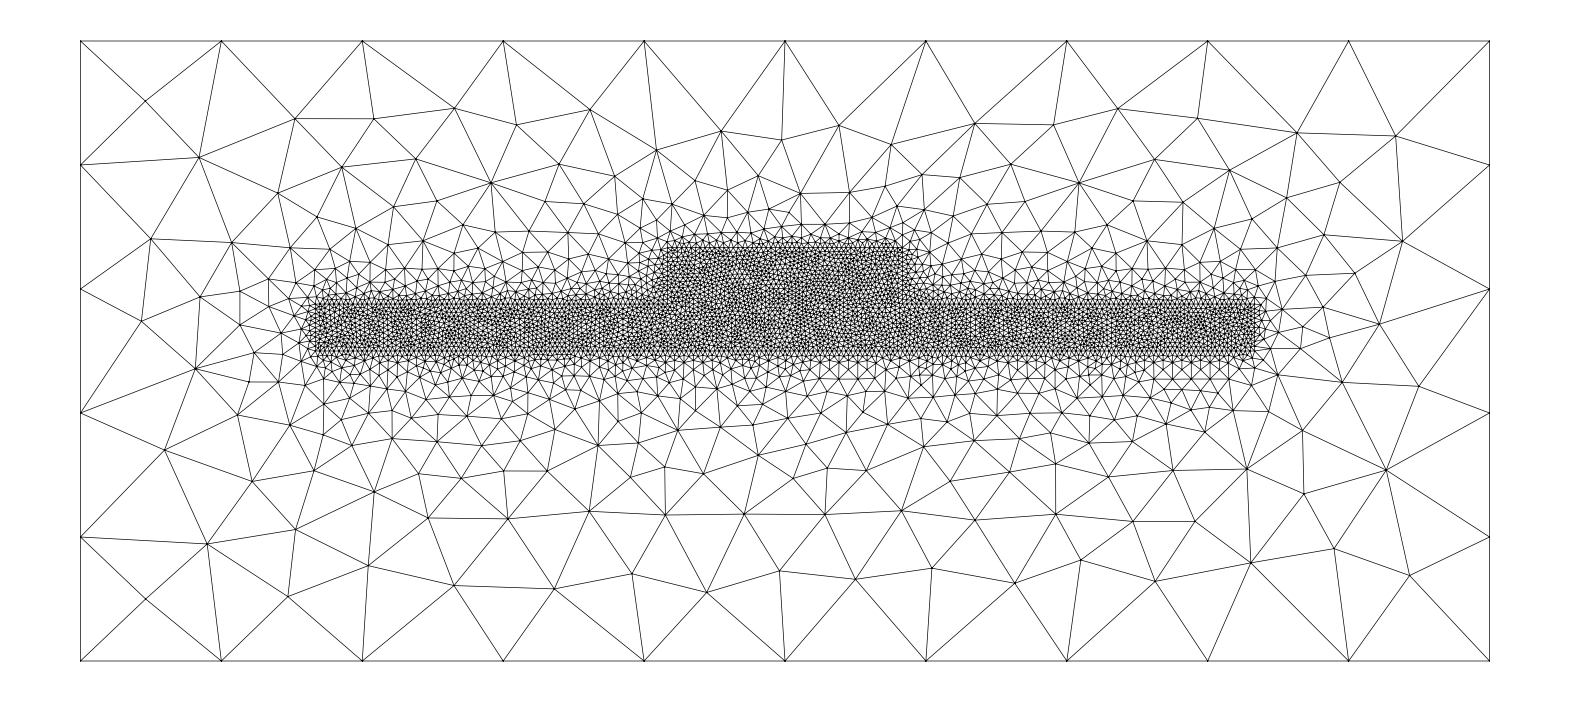

In [22]:
wg_width = 0.5
wg_thickness = 0.22

scale = 3

core = shapely.geometry.box(-wg_width / 2, 0, +wg_width / 2, wg_thickness)
rib = shapely.geometry.box(-2*wg_width, 0, +2*wg_width, rib_etch_thickness)

oxide = shapely.geometry.box(-scale*wg_width, -scale*wg_thickness, +scale*wg_width, scale*wg_thickness)
env = shapely.affinity.scale(core.buffer(5, resolution=8), xfact=0.5)

polygons = OrderedDict(
    core=shapely.union(core, rib),
    #box=clip_by_rect(env, -np.inf, -np.inf, np.inf, 0),
    #box=clip_by_rect(env, -np.inf, -np.inf, np.inf, np.inf)
    box=oxide
    #clad=clip_by_rect(env, -np.inf, 0, np.inf, np.inf),
)

resolutions = dict(core={"resolution": 0.01, "distance": 0.5})

mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=10))
mesh.draw().show()

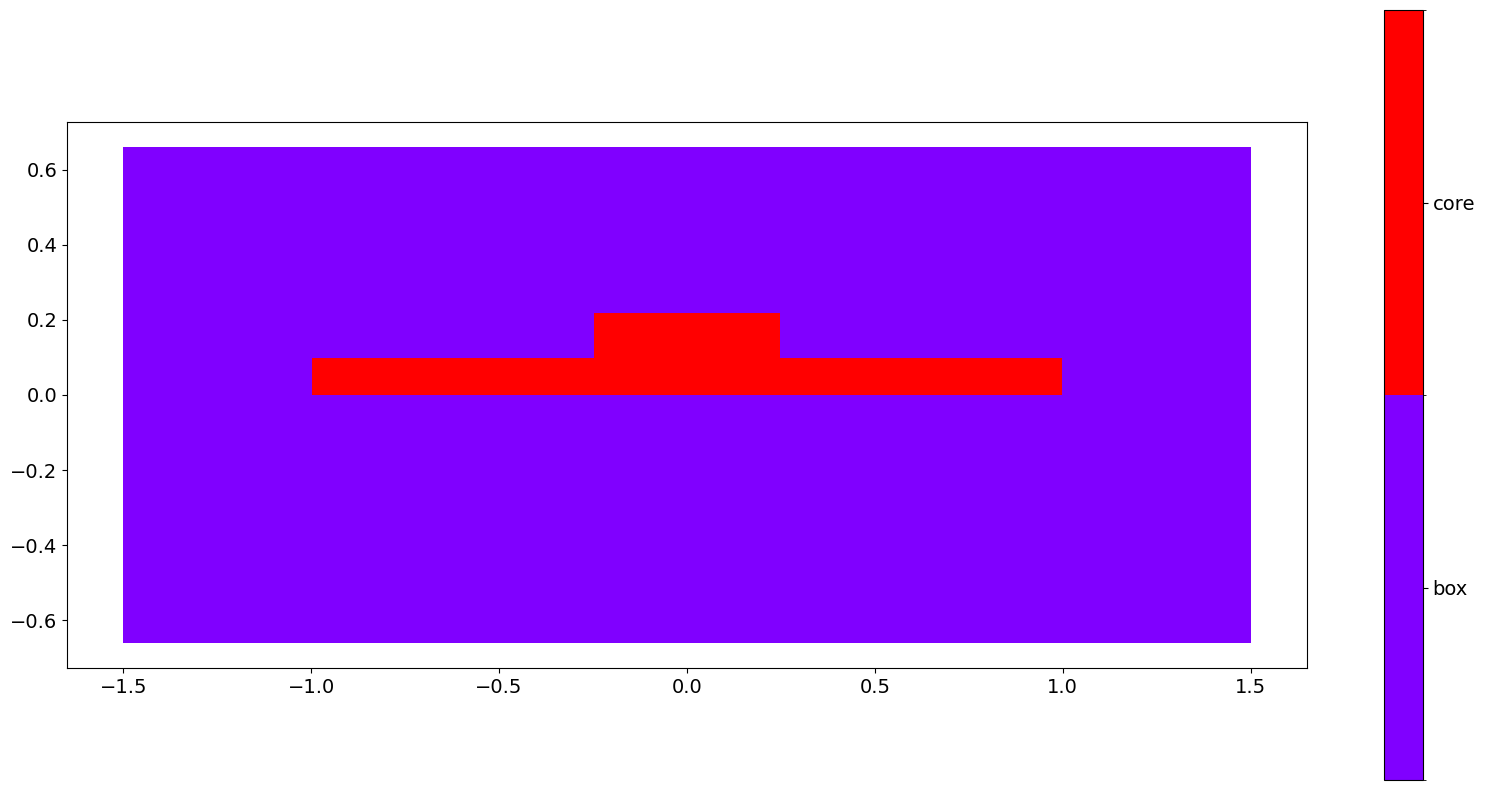

In [23]:
plot_domains(mesh)
plt.show()

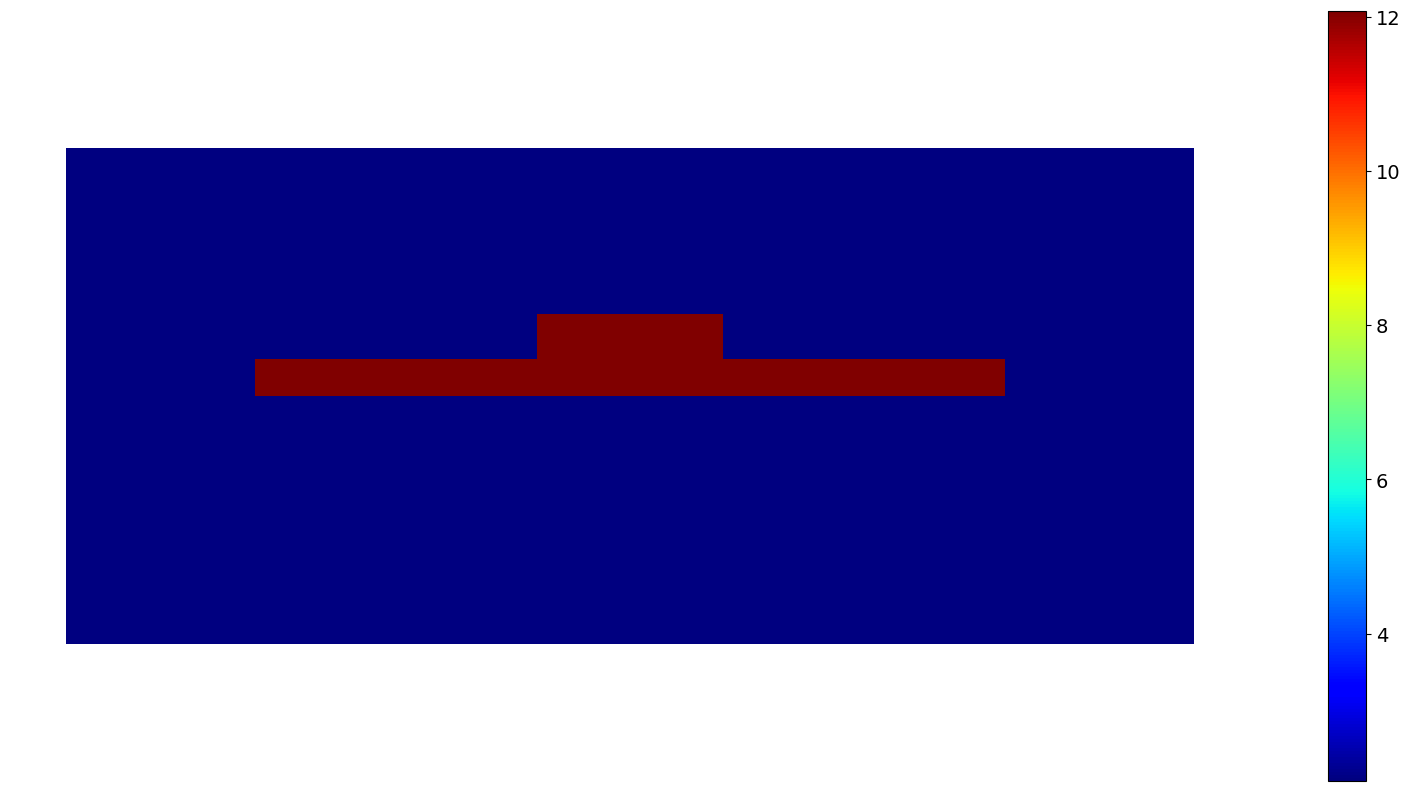

In [25]:
basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()

materials = {"core": n_si, "box": n_box}

for subdomain, n in materials.items():
    epsilon[basis0.get_dofs(elements=subdomain)] = n**2
basis0.plot(epsilon, colorbar=True).show()

Effective refractive index: 2.5850+0.0000j


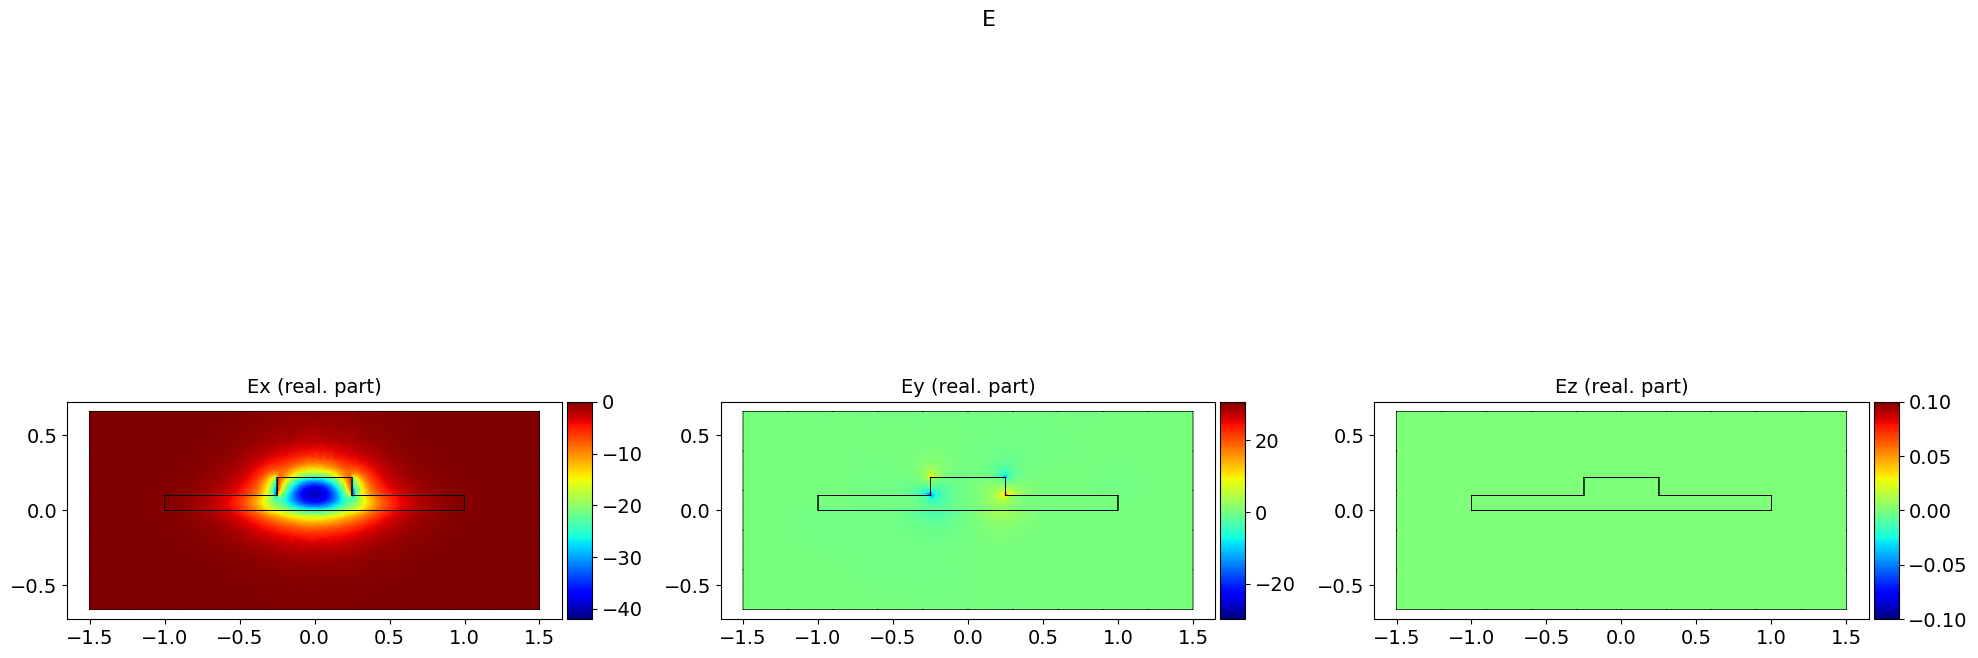

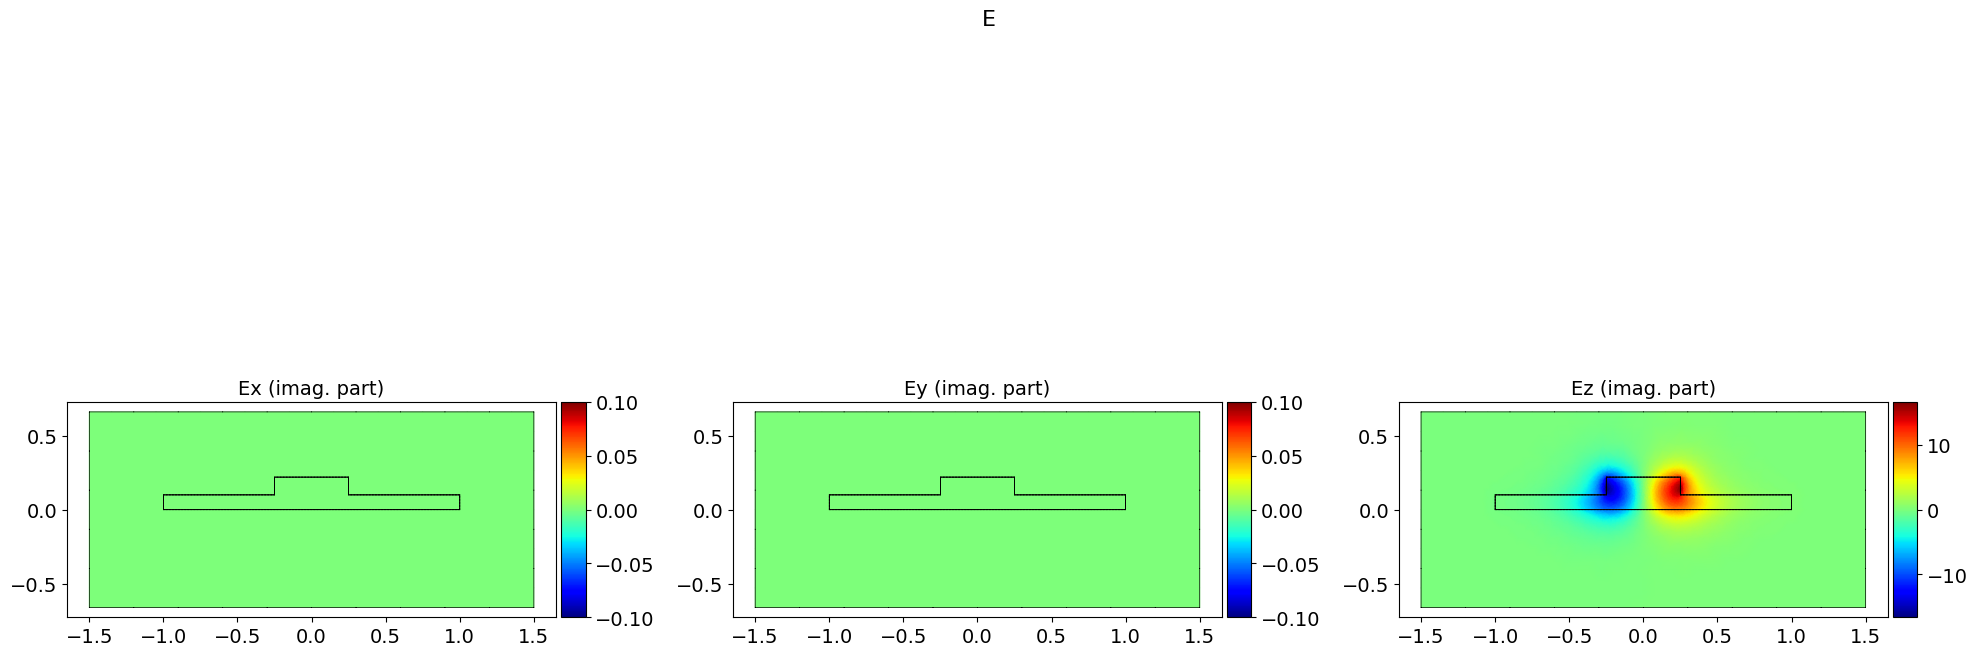

Effective refractive index: 2.1594+0.0000j


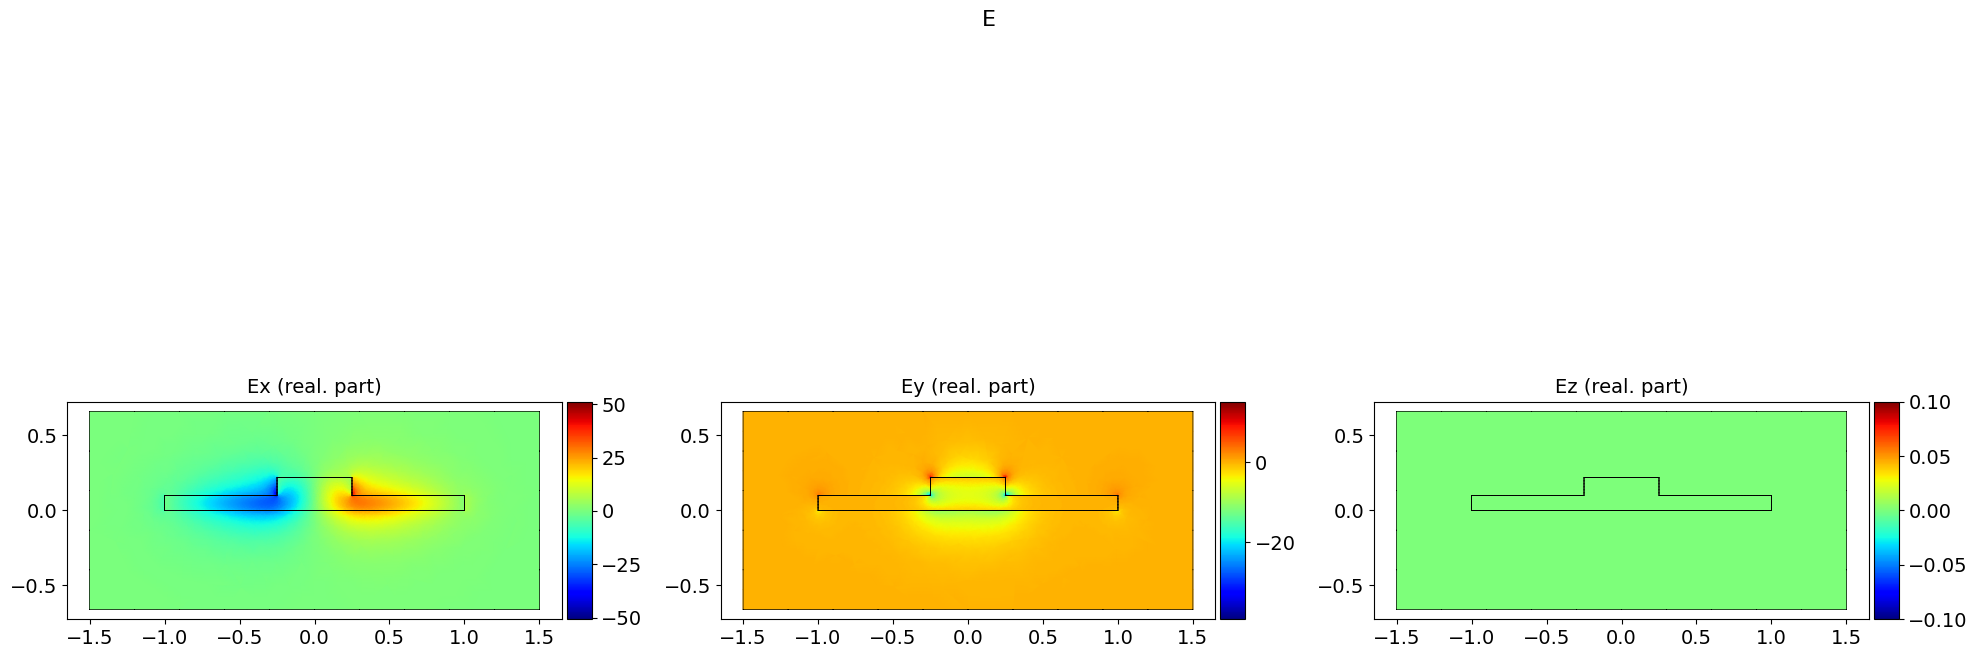

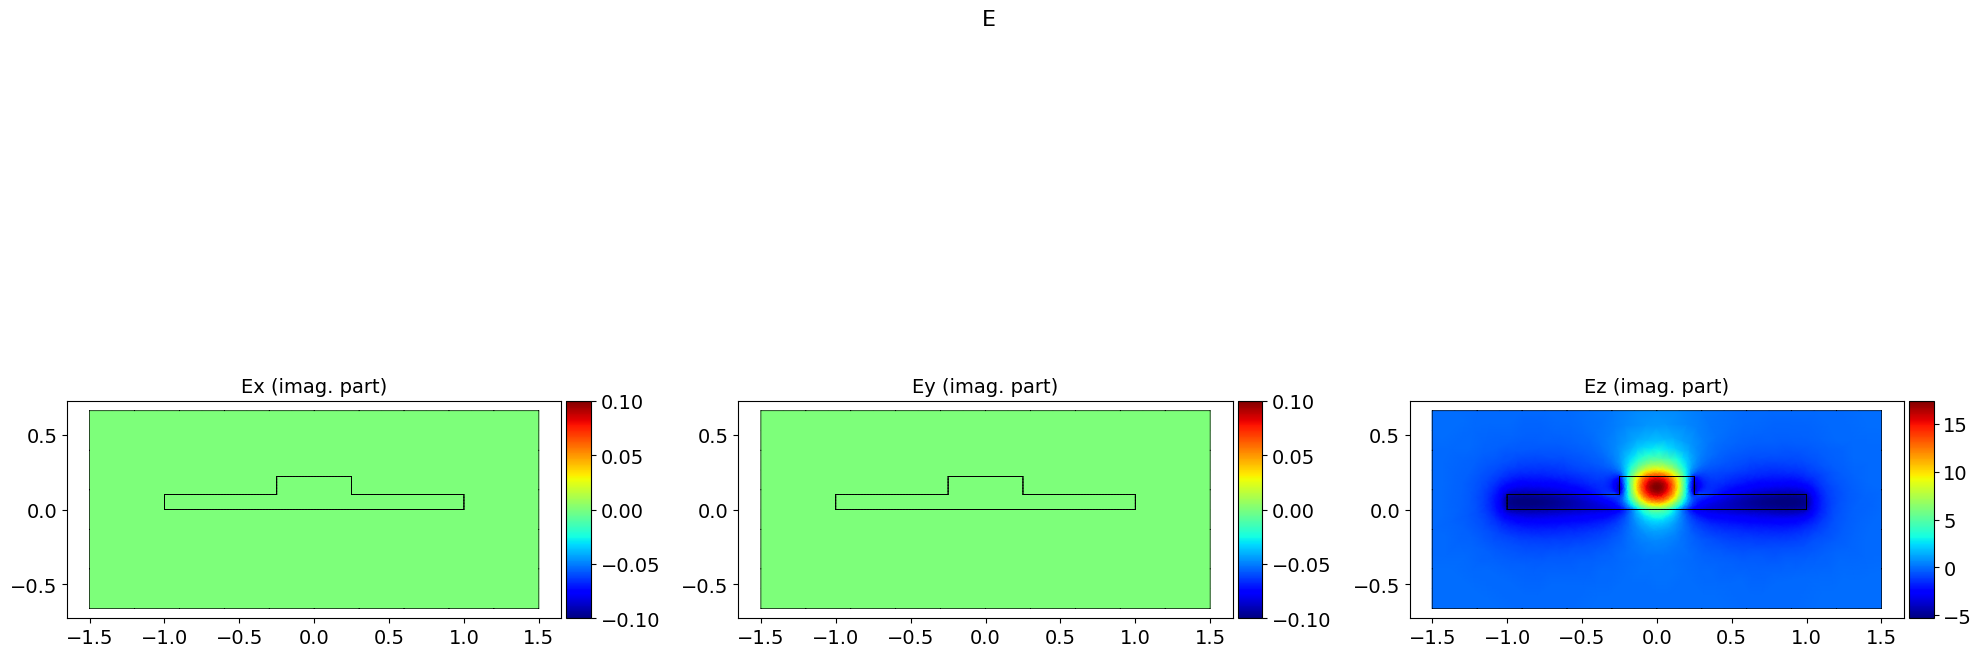

In [26]:
wavelength = 1.55

modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=2, order=2)

for mode in modes:
    print(f"Effective refractive index: {mode.n_eff:.4f}")
    mode.show("E", part="real", colorbar=True)
    mode.show("E", part="imag", colorbar=True)

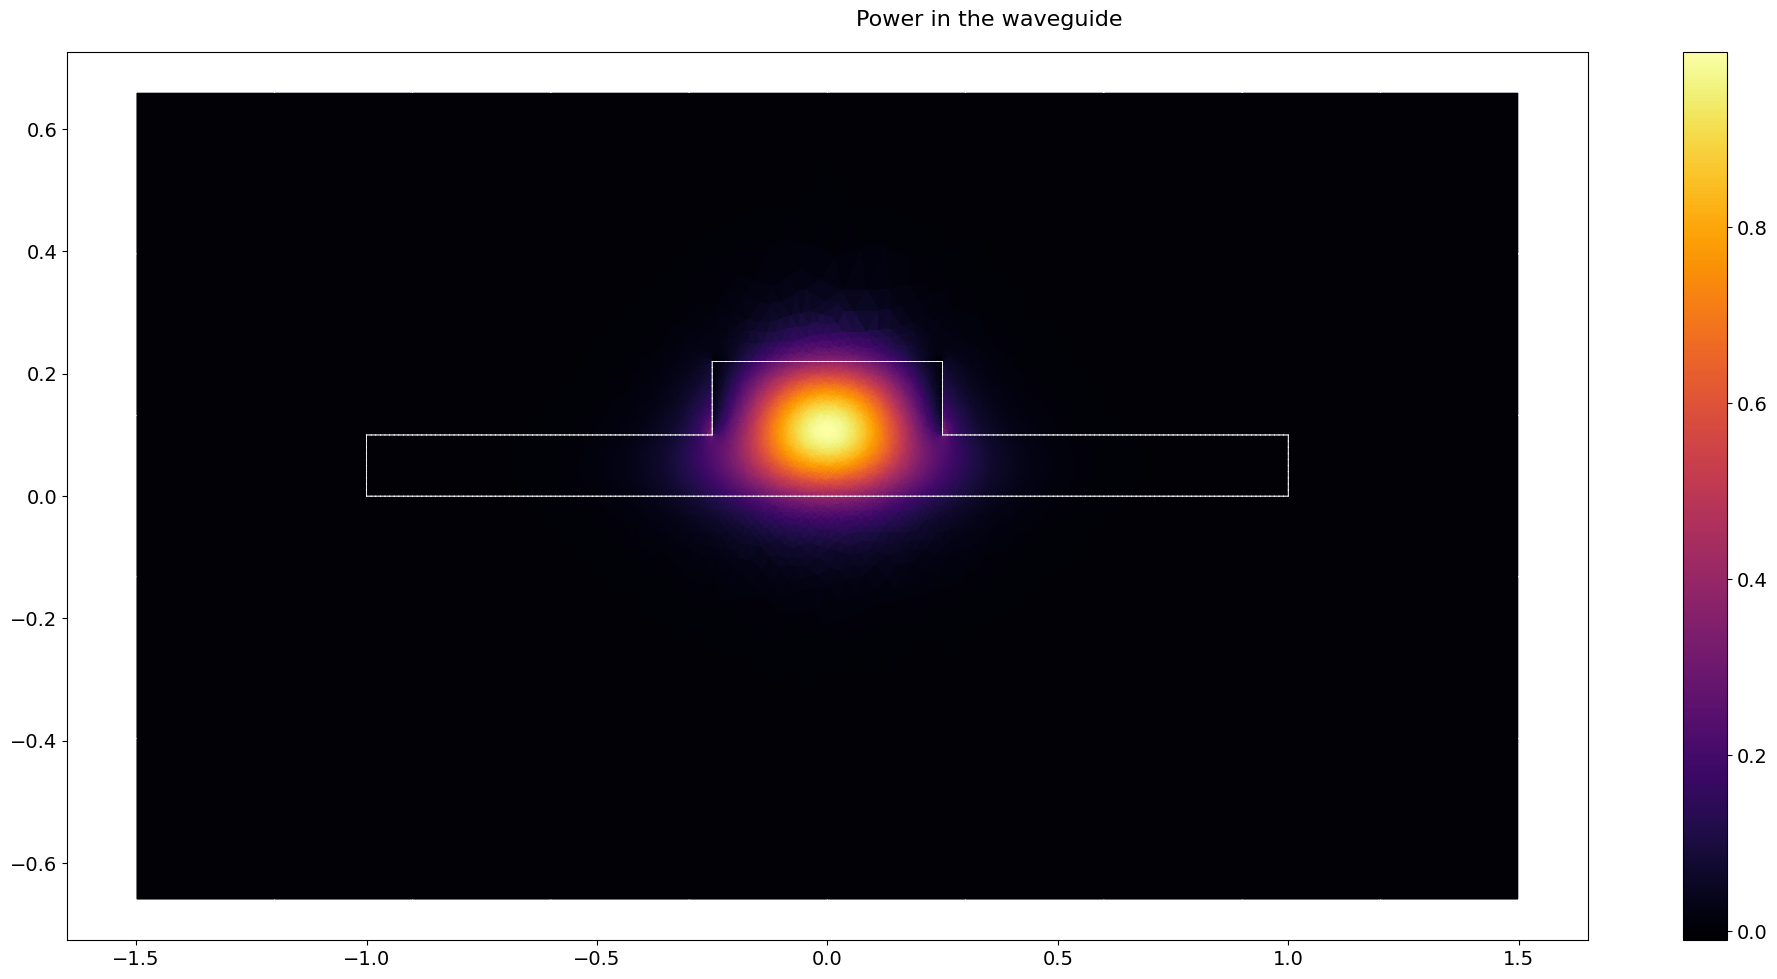

In [27]:
modes[0].show("I", colorbar=True, title="Power in the waveguide")

In [28]:
powers_in_waveguide = []
confinement_factors_waveguide = []

for mode in modes:
    powers_in_waveguide.append(mode.calculate_power(elements="core"))
    confinement_factors_waveguide.append(mode.calculate_confinement_factor(elements="core"))
print(powers_in_waveguide)
print(confinement_factors_waveguide)

[np.complex128(0.7572373063621994+0j), np.complex128(0.5160140633516337+0j)]
[np.complex128(1.0004131781479184+0j), np.complex128(0.8193392121798521+0j)]


## Waveguide width dependence

In [9]:
from tqdm import tqdm
from shapely.geometry import box

In [ ]:
wavelength = 1.55
num_modes = 4
widths = np.linspace(0.2, 0.8, 100)
height = 0.22
scale = 3

all_neffs = np.zeros((widths.shape[0], num_modes))
all_te_fracs = np.zeros((widths.shape[0], num_modes))

for i, width in enumerate(tqdm(widths)):
    core = box(-width / 2, 0, +width / 2, height)
    oxide = box(-scale*width, -scale*height, +scale*width, scale*height)
    env = shapely.affinity.scale(core.buffer(5, resolution=8), xfact=0.5)

    polygons = OrderedDict(core=core, box=oxide)

    resolutions = {"core": {"resolution": 0.01, "distance": 1}}

    mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=0.6))

    basis0 = Basis(mesh, ElementTriP0())
    epsilon = basis0.zeros(dtype=complex)
    for subdomain, n in {"core": n_si, "box": n_box}.items():
        epsilon[basis0.get_dofs(elements=subdomain)] = n**2

    modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=num_modes)
    all_neffs[i] = np.real([mode.n_eff for mode in modes])
    all_te_fracs[i, :] = [mode.te_fraction for mode in modes]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:10<00:00,  3.11s/it]


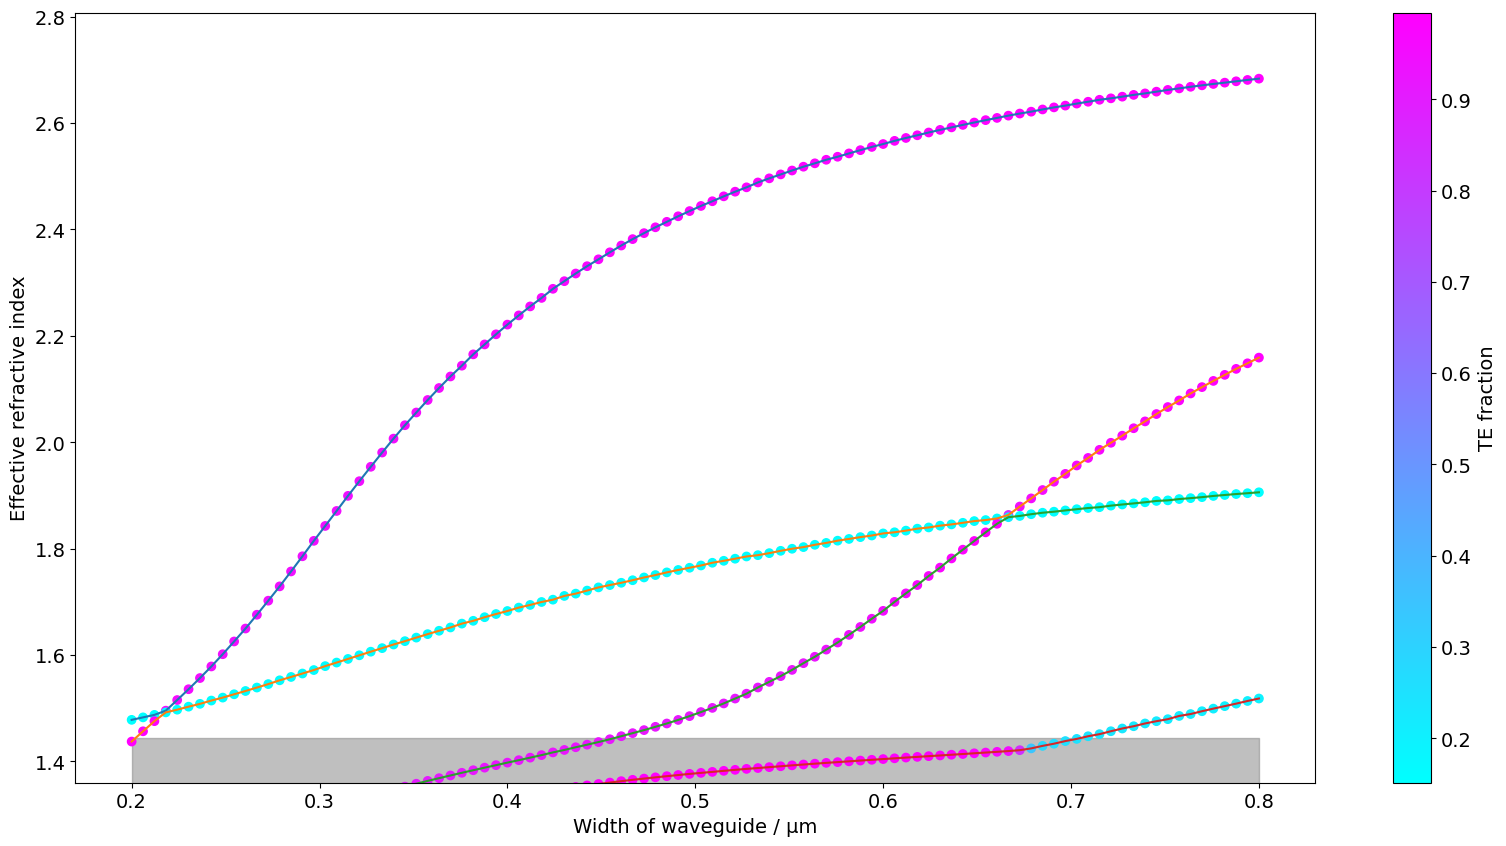

In [11]:
all_neffs = np.real(all_neffs)

plt.xlabel("Width of waveguide / µm")
plt.ylabel("Effective refractive index")
plt.fill_between(widths, 1.444, alpha=0.5, color="gray")
plt.ylim(1.36, np.max(all_neffs) + 0.1 * (np.max(all_neffs) - 1.444))

for lams, te_fracs in zip(all_neffs.T, all_te_fracs.T):
    plt.plot(widths, lams)
    plt.scatter(widths, lams, c=te_fracs, cmap="cool")
    
plt.colorbar().set_label("TE fraction")
plt.show()